In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['font.family'] = 'Arial'

import numpy as np
import pandas as pd
import seaborn as sns

from aind_analysis_arch_result_access.han_pipeline import get_session_table, get_mle_model_fitting
from aind_analysis_arch_result_access.util.s3 import get_s3_pkl, get_s3_json

### Load session table

In [3]:
# Get session table
df_session = get_session_table()

# Manually group curriculum versions (ver < 2.0, 2.0 <= ver < 2.3, ver >=2.3)
def _map_curriculum_ver(ver):
    if "2.3" in ver:
        return "v3"
    elif "1.0" in ver:
        return "v1"
    else:
        return "v2"

df_session["curriculum_version_group"] = df_session["curriculum_version"].map(_map_curriculum_ver)

### Download and cache model fitting results

In [9]:
df_model_fitting = get_mle_model_fitting(from_custom_query={"status": "success"}, if_include_latent_variables=False, paginate_settings={"paginate": True, "paginate_batch_size": 5000})

Query: {'analysis_spec.analysis_name': 'MLE fitting', 'analysis_spec.analysis_ver': 'first version @ 0.10.0', 'status': 'success'}
Found 145012 MLE fitting records!
Found 145012 successful MLE fitting!


In [12]:
df_model_fitting.to_pickle("~/capsule/results/df_model_fitting_all.pkl")

### Reload model fitting

In [4]:
df_model_fitting = pd.read_pickle("~/capsule/results/df_model_fitting_all.pkl")

### What we have?

Older sessions have 30 models fitted; newer sessions have 5.

In [6]:
n_models = df_model_fitting.value_counts("nwb_name")
n_models

nwb_name
757129_2024-09-27_09-27-32.nwb    30
757129_2024-09-16_10-03-58.nwb    30
757129_2024-09-17_09-55-41.nwb    30
757129_2024-09-18_10-18-30.nwb    30
757129_2024-09-19_09-53-24.nwb    30
                                  ..
747887_2024-09-29_15-18-07.nwb     5
748387_2024-10-23_09-53-43.nwb     5
748387_2024-10-24_10-15-20.nwb     5
748641_2024-10-21_12-07-51.nwb     5
747887_2024-10-05_16-14-46.nwb     5
Name: count, Length: 6965, dtype: int64

In [6]:
n_models.value_counts()

count
30    4253
5     2548
29     115
28      33
27       9
26       6
24       1
Name: count, dtype: int64

### Model comparison on sessions with all 30 models

In [13]:
df_model_fitting_30_filtered.columns

Index(['_id', 'nwb_name', 'status', 'agent_alias', 'log_likelihood', 'AIC',
       'BIC', 'LPT', 'LPT_AIC', 'LPT_BIC',
       ...
       'fitting_results_each_fold.8.params_without_polishing.epsilon',
       'fitting_results_each_fold.9.params.epsilon',
       'fitting_results_each_fold.9.params_without_polishing.epsilon',
       'params', 'prediction_accuracy_10-CV_test',
       'prediction_accuracy_10-CV_test_std', 'prediction_accuracy_10-CV_fit',
       'prediction_accuracy_10-CV_fit_std',
       'prediction_accuracy_10-CV_test_bias_only',
       'prediction_accuracy_10-CV_test_bias_only_std'],
      dtype='object', length=493)

In [26]:
df_model_fitting_30_filtered = df_model_fitting[df_model_fitting["nwb_name"].isin(n_models[n_models == 30].index)]
df_model_fitting_30_filtered = df_model_fitting_30_filtered.query("agent_alias.str.contains('WSLS') == False")
len(df_model_fitting_30_filtered)

114831

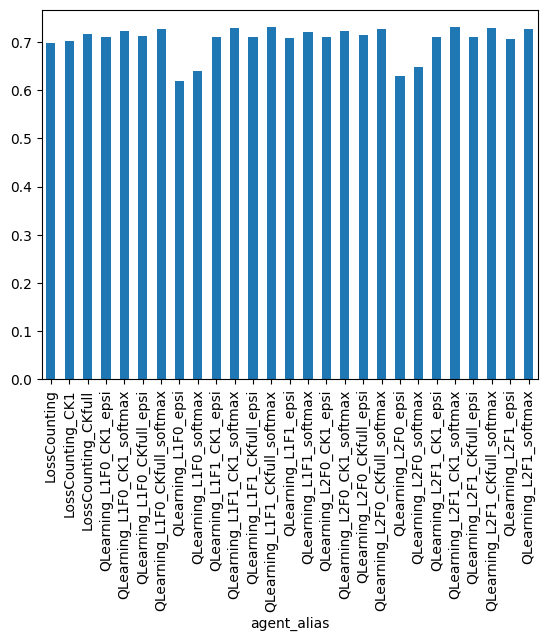

In [28]:
df_AIC_aver = df_model_fitting_30_filtered.groupby("agent_alias")["LPT_AIC"].mean()
ax = df_AIC_aver.plot(x="agent_alias", y="AIC", kind='bar')

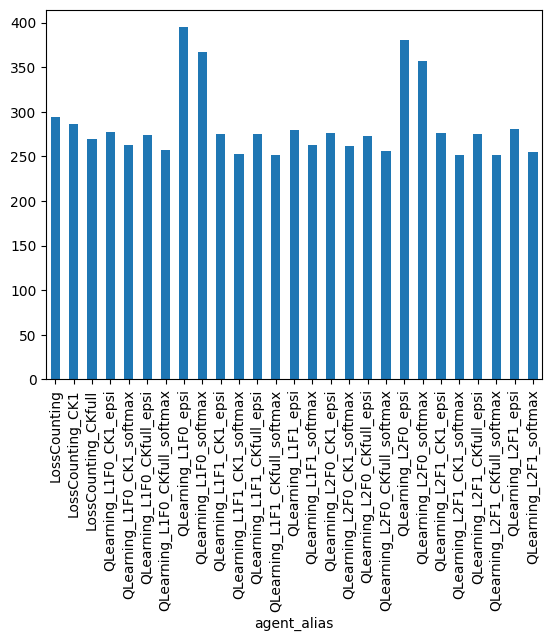

In [27]:
df_AIC_aver = df_model_fitting_30_filtered.groupby("agent_alias")["AIC"].mean()
ax = df_AIC_aver.plot(kind='bar')